# Imports

In [1]:
import os
import re
import nltk
import pandas as pd
import torch
import torch.nn as nn
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score
from torch.utils.data import Dataset
from transformers import BertModel, BertTokenizer
import matplotlib.pyplot as plt

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/storm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/storm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/storm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Preaparing Data

## Reading

### Gun violance

In [3]:
gun_context_spam = pd.read_csv('dataset/gun-violence/context-spam/published_data_spam-MLJ-2022_gun-violence_context-spam_context_spam_5000_no_link.csv')
gun_not_context_spam = pd.read_csv('dataset/gun-violence/context-spam/published_data_spam-MLJ-2022_gun-violence_context-spam_not_context_spam_5000_no_link.csv')
gun_context_spam.drop(['tweet_id'], axis=1, inplace=True)
gun_not_context_spam.drop(['tweet_id'], axis=1, inplace=True)
gun = pd.concat([gun_context_spam, gun_not_context_spam])
gun.reset_index(drop=True, inplace=True)

In [4]:
gun

,text,label
0,Stack-On PDS-1500 Gun Safe <em>URL01 Removed</...,1
1,#protection #safe Buy Now and be Safe <em>URL0...,1
2,I'm in the running to win the PolyCase - CZ P-...,1
3,"ZEV Technologies Prizefighter, a cheap Agency ...",1
4,I'm in the running to win a Springfield 1911 P...,1
...,...,...
4995,"Sai Baba! Sai Buhari! ""Dead men are getting ap...",0
4996,Alpha Krav Maga CT Pistol retention while firi...,0
4997,@USER01 “Uhm...Well...I’ll just be straightfor...,0
4998,The 2nd Amendment states it it PLAIN LANGUAGE ...,0


### MeToo

In [5]:
metoo_context_spam = pd.read_csv('dataset/metoo/context-spam/published_data_spam-MLJ-2022_metoo_context-spam_context_spam_5000_no_link.csv')
metoo_not_context_spam = pd.read_csv('dataset/metoo/context-spam/published_data_spam-MLJ-2022_metoo_context-spam_not_context_spam_5000_no_link.csv')
metoo_context_spam.drop(['tweet_id'], axis=1, inplace=True)
metoo_not_context_spam.drop(['tweet_id'], axis=1, inplace=True)
metoo = pd.concat([metoo_context_spam, metoo_not_context_spam])
metoo.reset_index(drop=True, inplace=True)

In [6]:
metoo

,text,label
0,Check out the latest happening in #events. #Ev...,1
1,"Will b at #Half-PriceBooks, 15146 5/12: book s...",1
2,Thursday at 12 noon CT URL01_Removed recaps 5 ...,1
3,Move To #LosAngeles - Come #Glow Up And Be A S...,1
4,Men's Sweater Hoodie Fashion Casual Slim Ch......,1
...,...,...
4995,This started when i was 6. A elderly man who h...,0
4996,Meet the woman who started #MeToo 10 years ago...,0
4997,@USER01 @USER02 @USER03 @USER04 #MeToo and no ...,0
4998,@USER01 @USER02 Correct. But she’s not talking...,0


### Parenting

In [7]:
parenting_context_spam = pd.read_csv('dataset/parenting/context-spam/published_data_spam-MLJ-2022_parenting_context-spam_context_spam_5000_no_link.csv')
parenting_not_context_spam = pd.read_csv('dataset/parenting/context-spam/published_data_spam-MLJ-2022_parenting_context-spam_not_context_spam_5000_no_link.csv')
parenting_context_spam.drop(['tweet_id'], axis=1, inplace=True)
parenting_not_context_spam.drop(['tweet_id'], axis=1, inplace=True)
parenting = pd.concat([parenting_context_spam, parenting_not_context_spam])
parenting.reset_index(drop=True, inplace=True)

In [8]:
parenting

,text,label
0,Pura Stainless Drinking Bottles Bundle Prizepa...,1
1,LG’s Twin Wash System @USER02 Is Everything Yo...,1
2,#AD #GetActiveAtWalmart Enter to #win some awe...,1
3,@USER01 tweet me when your hosting these givea...,1
4,Giveaway! Three Winners! Scribblenauts™ Showdo...,1
...,...,...
4995,@USER01 We sure can! Give us a quick call when...,0
4996,This Windex ad about kids growing up is making...,0
4997,Tips for surviving Daylight Savings Time - <em...,0
4998,The Lane Bryant ad the networks didn't want yo...,0


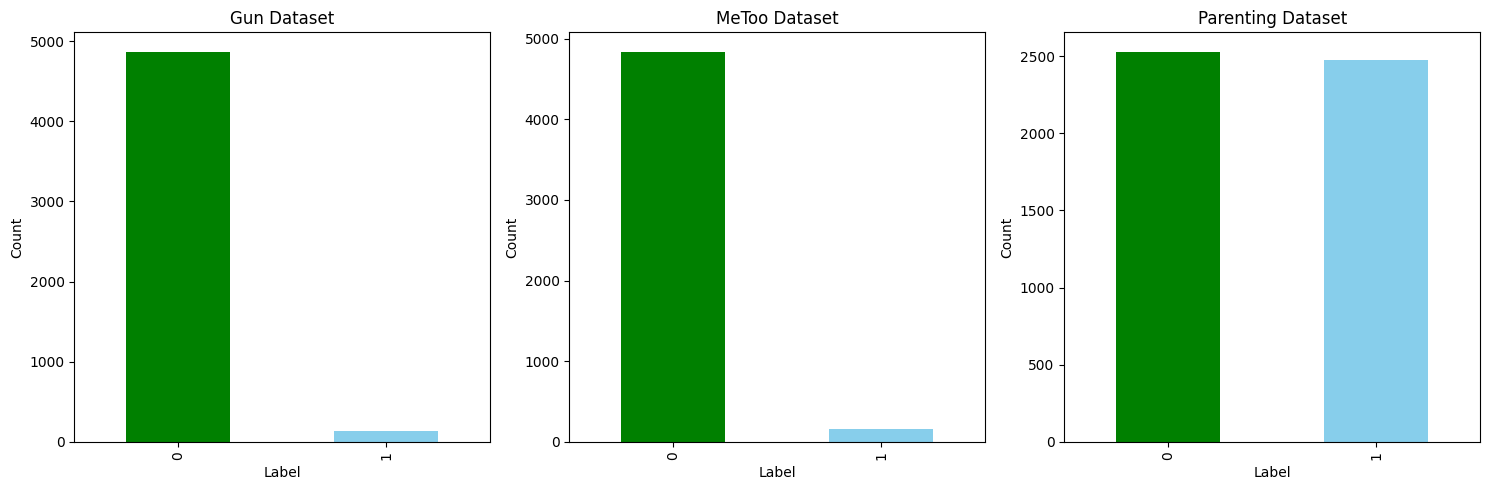

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

gun_labels = gun['label'].value_counts()
gun_labels.plot(kind='bar', ax=axs[0], color=['green', 'skyblue'])
axs[0].set_title('Gun Dataset')
axs[0].set_xlabel('Label')
axs[0].set_ylabel('Count')

metoo_labels = metoo['label'].value_counts()
metoo_labels.plot(kind='bar', ax=axs[1], color=['green', 'skyblue'])
axs[1].set_title('MeToo Dataset')
axs[1].set_xlabel('Label')
axs[1].set_ylabel('Count')

parenting_labels = parenting['label'].value_counts()
parenting_labels.plot(kind='bar', ax=axs[2], color=['green', 'skyblue'])
axs[2].set_title('Parenting Dataset')
axs[2].set_xlabel('Label')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Cleaning

In [16]:
def clean_text(text):
    text = re.sub(r"@\w+", "", text)
    
    text = re.sub(r"<em>.*?</em>", "", text)
    
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    
    text = re.sub(r"[^\w\s]", "", text)
    
    text = re.sub(r"\d+", "", text)
    
    text = text.lower()
    
    tokens = word_tokenize(text)
    
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]
    cleaned_text = " ".join(lemmatized_tokens)
    
    return cleaned_text

In [18]:
before = parenting['text'].array[0]
after = clean_text(before)
print(f'Before: {before}')
print(f'After: {after}')

Before: Pura Stainless Drinking Bottles Bundle Prizepack Giveaway @USER02 @USER03
<em>URL01 Removed</em> <em>URL02 Removed</em>
After: pura stainless drink bottl bundl prizepack giveaway


In [10]:
gun['text'] = gun['text'].apply(clean_text)
metoo['text'] = metoo['text'].apply(clean_text)
parenting['text'] = parenting['text'].apply(clean_text)

## Spliting

In [11]:
gun_train, gun_test = train_test_split(
    gun, test_size=0.1, random_state=42, stratify=gun['label'])
gun_train, gun_val = train_test_split(
    gun_train, test_size=0.1, random_state=42, stratify=gun_train['label'])

gun_train = pd.DataFrame(gun_train, columns=gun.columns)
gun_test = pd.DataFrame(gun_test, columns=gun.columns)
gun_val = pd.DataFrame(gun_val, columns=gun.columns)

metoo_train, metoo_test = train_test_split(
    metoo, test_size=0.1, random_state=42, stratify=metoo['label'])
metoo_train, metoo_val = train_test_split(
    metoo_train, test_size=0.1, random_state=42, stratify=metoo_train['label'])

metoo_train = pd.DataFrame(metoo_train, columns=metoo.columns)
metoo_test = pd.DataFrame(metoo_test, columns=metoo.columns)
metoo_val = pd.DataFrame(metoo_val, columns=metoo.columns)

parenting_train, parenting_test = train_test_split(
    parenting, test_size=0.1, random_state=42, stratify=parenting['label'])
parenting_train, parenting_val = train_test_split(
    parenting_train, test_size=0.1, random_state=42, stratify=parenting_train['label'])

parenting_train = pd.DataFrame(parenting_train, columns=parenting.columns)
parenting_test = pd.DataFrame(parenting_test, columns=parenting.columns)
parenting_val = pd.DataFrame(parenting_val, columns=parenting.columns)

gun_train.reset_index(drop=True, inplace=True)
gun_test.reset_index(drop=True, inplace=True)
gun_val.reset_index(drop=True, inplace=True)

metoo_train.reset_index(drop=True, inplace=True)
metoo_test.reset_index(drop=True, inplace=True)
metoo_val.reset_index(drop=True, inplace=True)

parenting_train.reset_index(drop=True, inplace=True)
parenting_test.reset_index(drop=True, inplace=True)
parenting_val.reset_index(drop=True, inplace=True)


# Feature Extraction

## Bag Of Words

In [ ]:
vectorizer = CountVectorizer()

### Parenting

In [ ]:
parenting_train_bow = vectorizer.fit_transform(parenting_train['text'])
parenting_test_bow = vectorizer.transform(parenting_test['text'])
parenting_train_bow = parenting_train_bow.toarray()
parenting_test_bow = parenting_test_bow.toarray()

### Gun

In [ ]:
gun_train_bow = vectorizer.fit_transform(gun_train['text'])
gun_test_bow = vectorizer.transform(gun_test['text'])
gun_train_bow = gun_train_bow.toarray()
gun_test_bow = gun_test_bow.toarray()

### MeToo

In [ ]:
metoo_train_bow = vectorizer.fit_transform(metoo_train['text'])
metoo_test_bow = vectorizer.transform(metoo_test['text'])
metoo_train_bow = metoo_train_bow.toarray()
metoo_test_bow = metoo_test_bow.toarray()

# Classic Algorithms

## Random Forest

In [ ]:
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [2, 4, 8, 16],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_model = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='f1_macro')

### Parenting

In [ ]:
grid_search.fit(parenting_train_bow, parenting_train['label'])

best_params = grid_search.best_params_
print('Best Parameters:', best_params)
best_model = grid_search.best_estimator_

parenting_rf_pred = best_model.predict(parenting_test_bow)

### Gun

In [ ]:
grid_search.fit(gun_train_bow, gun_train['label'])

best_params = grid_search.best_params_
print('Best Parameters:', best_params)
best_model = grid_search.best_estimator_

gun_rf_pred = best_model.predict(gun_test_bow)

### MeToo

In [ ]:
grid_search.fit(metoo_train_bow, metoo_train['label'])

best_params = grid_search.best_params_
print('Best Parameters:', best_params)
best_model = grid_search.best_estimator_

metoo_rf_pred = best_model.predict(metoo_test_bow)

# Neural Network

## Model

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [13]:
class MyModel(nn.Module):
    def __init__(self, bert_model):
        super(MyModel, self).__init__()
        self.bert_model = bert_model
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.bert_model.config.hidden_size, 2)

    def forward(self, inputs):
        outputs = self.bert_model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        bert_output = last_hidden_state[:, 0, :]
        dropout_output = self.dropout(bert_output)
        linear_output = self.linear(dropout_output)
        return linear_output

## Loading Data

In [14]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [15]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer
        return
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.loc[idx, 'text']
        label = self.df.loc[idx, 'label']
        tokenized = self.tokenizer(text, padding='max_length', truncation=True, max_length=512, return_tensors='pt')
        output = {
            'input_ids': tokenized['input_ids'].flatten(),
            'attention_mask': tokenized['attention_mask'].flatten(),
            'label': torch.tensor(label)
        }
        return output

### Datasets

In [16]:
gun_train_dataset = CustomDataset(gun_train, bert_tokenizer)
gun_val_dataset = CustomDataset(gun_val, bert_tokenizer)
gun_test_dataset = CustomDataset(gun_test, bert_tokenizer)

metoo_train_dataset = CustomDataset(metoo_train, bert_tokenizer)
metoo_val_dataset = CustomDataset(metoo_val, bert_tokenizer)
metoo_test_dataset = CustomDataset(metoo_test, bert_tokenizer)

parenting_train_dataset = CustomDataset(parenting_train, bert_tokenizer)
parenting_val_dataset = CustomDataset(parenting_val, bert_tokenizer)
parenting_test_dataset = CustomDataset(parenting_test, bert_tokenizer)

### Data Loaders

In [17]:
batch_size = 20
num_epochs = 20

gun_train_dataloader = torch.utils.data.DataLoader(gun_train_dataset, batch_size=batch_size, shuffle=True)
gun_val_dataloader = torch.utils.data.DataLoader(gun_val_dataset, batch_size=batch_size, shuffle=True)
gun_test_dataloader = torch.utils.data.DataLoader(gun_test_dataset, batch_size=batch_size, shuffle=True)

metoo_train_dataloader = torch.utils.data.DataLoader(metoo_train_dataset, batch_size=batch_size, shuffle=True)
metoo_val_dataloader = torch.utils.data.DataLoader(metoo_val_dataset, batch_size=batch_size, shuffle=True)
metoo_test_dataloader = torch.utils.data.DataLoader(metoo_test_dataset, batch_size=batch_size, shuffle=True)

parenting_train_dataloader = torch.utils.data.DataLoader(parenting_train_dataset, batch_size=batch_size, shuffle=True)
parenting_val_dataloader = torch.utils.data.DataLoader(parenting_val_dataset, batch_size=batch_size, shuffle=True)
parenting_test_dataloader = torch.utils.data.DataLoader(parenting_test_dataset, batch_size=batch_size, shuffle=True)

## Learning

In [18]:
def train_model(bert_model, train_dataloader, validation_dataloader) -> MyModel:
    bert_model = bert_model.to(device)
    my_model = MyModel(bert_model)
    my_model = my_model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(my_model.parameters(), lr=0.000005)

    best_precision_macro = 0.0
    patience = 3
    counter = 0

    for epoch in range(20):
        running_loss = 0.0
        total_predictions = []
        total_labels = []

        for batch in train_dataloader:
            inputs = {key: value.to(device) for key, value in batch.items() if key != 'label'}
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = my_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            predictions = torch.argmax(probabilities, dim=1)
            total_predictions.extend(predictions.cpu().numpy())
            total_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_dataloader)
        epoch_f1_macro = f1_score(total_labels, total_predictions, average='macro')
        epoch_precision_macro = precision_score(total_labels, total_predictions, average='macro')
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, F1 Macro: {epoch_f1_macro:.4f}, Precision Macro: {epoch_precision_macro:.4f}")

        # Validation
        my_model.eval()
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for val_batch in validation_dataloader:
                val_inputs = {key: value.to(device) for key, value in val_batch.items() if key != 'label'}
                val_labels_batch = val_batch['label'].to(device)

                val_outputs = my_model(val_inputs)
                val_probabilities = torch.nn.functional.softmax(val_outputs, dim=1)
                val_predictions_batch = torch.argmax(val_probabilities, dim=1)
                val_predictions.extend(val_predictions_batch.cpu().numpy())
                val_labels.extend(val_labels_batch.cpu().numpy())

        val_precision_macro = precision_score(val_labels, val_predictions, average='macro')
        print(f"Validation Precision Macro: {val_precision_macro:.4f}")

        if val_precision_macro > best_precision_macro:
            best_precision_macro = val_precision_macro
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered. Training stopped.")
                break

        my_model.train()
    
    return my_model

### Parenting

In [19]:
model_file = 'models/parenting_model.pth'
parenting_bert_model = BertModel.from_pretrained('bert-base-uncased')

if os.path.isfile(model_file):
    parenting_model = MyModel(parenting_bert_model)
    parenting_model.load_state_dict(torch.load(model_file))
    parenting_model = parenting_model.to(device)
else:
    parenting_model = train_model(parenting_bert_model, parenting_train_dataloader, parenting_val_dataloader)
    torch.save(parenting_model.state_dict(), model_file)

Epoch 1/20, Loss: 0.4987, F1 Macro: 0.7593, Precision Macro: 0.7595
Validation Precision Macro: 0.8134
Epoch 2/20, Loss: 0.3979, F1 Macro: 0.8257, Precision Macro: 0.8257
Validation Precision Macro: 0.8181
Epoch 3/20, Loss: 0.3251, F1 Macro: 0.8657, Precision Macro: 0.8657
Validation Precision Macro: 0.8278
Epoch 4/20, Loss: 0.2791, F1 Macro: 0.8874, Precision Macro: 0.8874
Validation Precision Macro: 0.8290
Epoch 5/20, Loss: 0.2170, F1 Macro: 0.9160, Precision Macro: 0.9161
Validation Precision Macro: 0.8267
Epoch 6/20, Loss: 0.1878, F1 Macro: 0.9304, Precision Macro: 0.9304
Validation Precision Macro: 0.8226
Epoch 7/20, Loss: 0.1532, F1 Macro: 0.9405, Precision Macro: 0.9405
Validation Precision Macro: 0.8074
Early stopping triggered. Training stopped.


### Gun

In [28]:
model_file = 'models/gun_model.pth'
gun_bert_model = BertModel.from_pretrained('bert-base-uncased')

if os.path.isfile(model_file):
    gun_model = MyModel(parenting_bert_model)
    gun_model.load_state_dict(torch.load(model_file))
    gun_model = gun_model.to(device)
else:
    gun_model = train_model(gun_bert_model, gun_train_dataloader, gun_val_dataloader)
    torch.save(gun_model.state_dict(), model_file)

Epoch 1/20, Loss: 0.1103, F1 Macro: 0.6179
Validation F1 Macro: 0.4932
Epoch 2/20, Loss: 0.0545, F1 Macro: 0.7639
Validation F1 Macro: 0.7684
Epoch 3/20, Loss: 0.0371, F1 Macro: 0.8674
Validation F1 Macro: 0.7473
Epoch 4/20, Loss: 0.0290, F1 Macro: 0.9116
Validation F1 Macro: 0.7241
Epoch 5/20, Loss: 0.0199, F1 Macro: 0.9398
Validation F1 Macro: 0.7408
Early stopping triggered. Training stopped.


### MeToo

In [ ]:
model_file = 'models/metoo_model.pth'
metoo_bert_model = BertModel.from_pretrained('bert-base-uncased')

if os.path.isfile(model_file):
    metoo_model = MyModel(metoo_bert_model)
    metoo_model.load_state_dict(torch.load(model_file))
    metoo_model = metoo_model.to(device)
else:
    metoo_model= train_model(metoo_bert_model, metoo_train_dataloader, metoo_val_dataloader)
    torch.save(metoo_model.state_dict(), model_file)

# Testing

In [22]:
def report(test, pred):
    print("Classification Report:")
    print(classification_report(test, pred))
    cm = confusion_matrix(test, pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['not spam', 'spam'])
    disp.plot()
    plt.show()

In [21]:
def test_model(my_model, test_dataloader):
    my_model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for test_batch in test_dataloader:
            test_inputs = {key: value.to(device) for key, value in test_batch.items() if key != 'label'}
            test_labels = test_batch['label'].to(device)

            test_outputs = my_model(test_inputs)
            test_probabilities = torch.nn.functional.softmax(test_outputs, dim=1)
            test_predictions = torch.argmax(test_probabilities, dim=1)

            true_labels.extend(test_labels.cpu().numpy())
            predicted_labels.extend(test_predictions.cpu().numpy())

    report(true_labels, predicted_labels)

## Within Domain

### Parenting

#### Neural Network

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       253
           1       0.82      0.71      0.76       247

    accuracy                           0.78       500
   macro avg       0.79      0.78      0.78       500
weighted avg       0.79      0.78      0.78       500



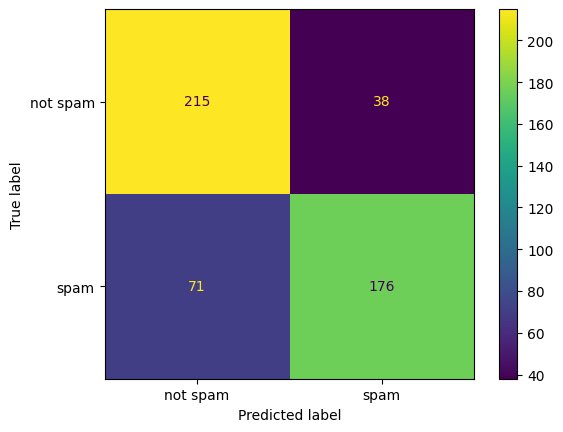

In [23]:
test_model(parenting_model, parenting_test_dataloader)

#### Random Forest

In [ ]:
report(parenting_test['label'], parenting_rf_pred)

### Gun

#### Neural Network

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       487
           1       0.50      0.77      0.61        13

    accuracy                           0.97       500
   macro avg       0.75      0.87      0.80       500
weighted avg       0.98      0.97      0.98       500



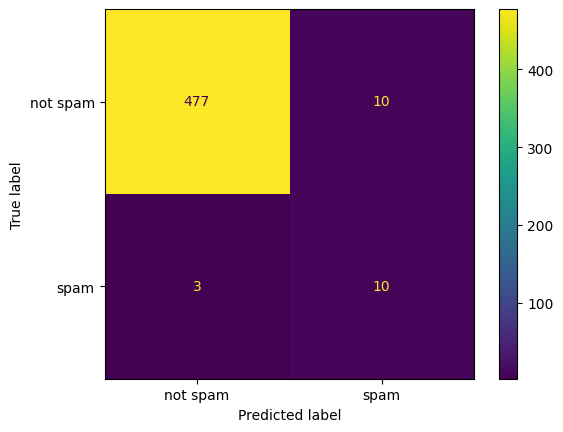

In [31]:
test_model(gun_model, gun_test_dataloader)

#### Random Forest

In [ ]:
report(gun_test['label'], gun_rf_pred)

### MeToo

#### Neural Network

In [ ]:
test_model(metoo_model, metoo_test_dataloader)

#### Random Forest

In [ ]:
report(metoo_test['label'], metoo_rf_pred)

## Cross Domain

### Parenting Model

#### Gun Data

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.79      0.88       487
           1       0.10      0.85      0.17        13

    accuracy                           0.79       500
   macro avg       0.55      0.82      0.53       500
weighted avg       0.97      0.79      0.86       500



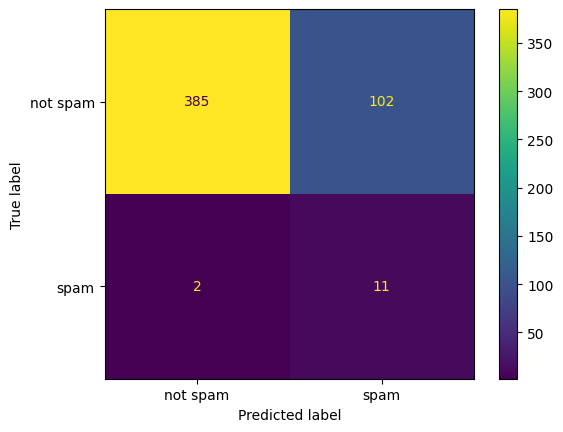

In [26]:
test_model(parenting_model, gun_test_dataloader)

#### MeToo Data

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88       484
           1       0.12      0.81      0.20        16

    accuracy                           0.80       500
   macro avg       0.55      0.81      0.54       500
weighted avg       0.96      0.80      0.86       500



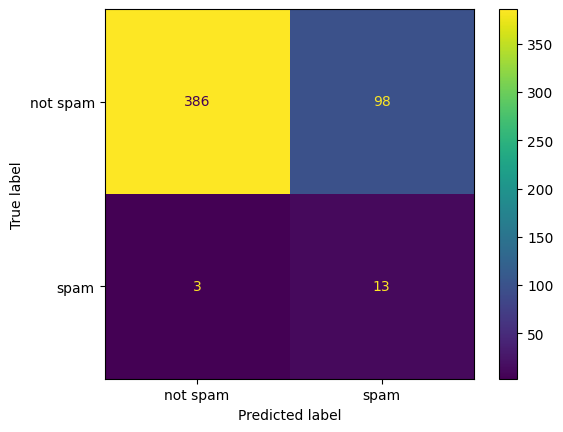

In [27]:
test_model(parenting_model, metoo_test_dataloader)

### Gun Model

#### Parenting Data

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.98      0.71       253
           1       0.91      0.21      0.34       247

    accuracy                           0.60       500
   macro avg       0.73      0.59      0.52       500
weighted avg       0.73      0.60      0.53       500



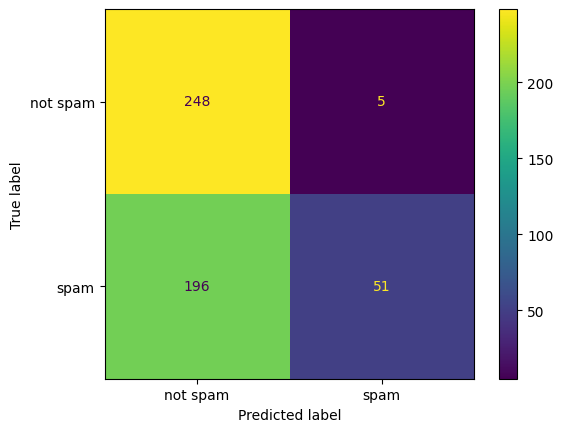

In [32]:
test_model(gun_model, parenting_test_dataloader)

#### MeToo Data

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       484
           1       0.00      0.00      0.00        16

    accuracy                           0.97       500
   macro avg       0.48      0.50      0.49       500
weighted avg       0.94      0.97      0.95       500



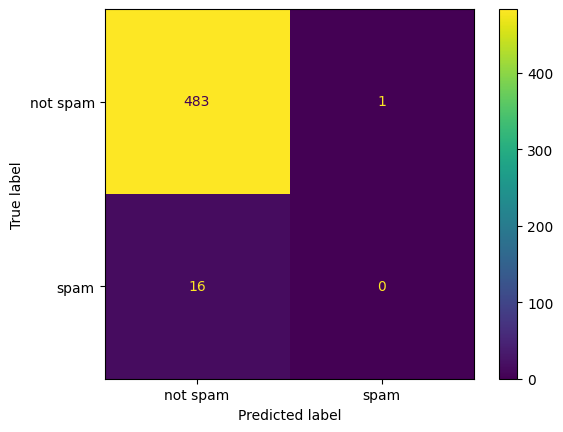

In [33]:
test_model(gun_model, metoo_test_dataloader)

### MeToo Model

#### Gun Data

In [ ]:
test_model(metoo_model, gun_test_dataloader)

#### Parenting Data

In [ ]:
test_model(metoo_model, parenting_test_dataloader)